In [7]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel

In [ ]:
# Константы
DATA_PATH = "../data/processed/context_answer.csv"
OUTPUT_DIR = "../models"
BATCH_SIZE = 16
MODEL_NAME = 'bert-base-uncased'

In [ ]:
# Загрузка предобученной модели и токенизатора
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

# Переносим модель на GPU, если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [1]:
def get_bert_embedding(texts, model, tokenizer, batch_size=16):
    """Получает эмбеддинги для нескольких текстов с помощью BERT."""
    # Токенизация в батчах
    inputs = tokenizer(
        texts, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=512
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Переносим данные на GPU

    with torch.no_grad():
        outputs = model(**inputs)

    # Используем среднее значение эмбеддингов токенов как вектор текста
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Переносим обратно на CPU
    return embeddings


def load_data(data_path):
    """Загружает обработанные данные."""
    return pd.read_csv(data_path)


def save_embeddings(embeddings, output_path):
    """Сохраняет эмбеддинги в файл."""
    if embeddings.ndim > 2:
        raise ValueError(f"Ожидался двумерный массив, но получен массив формы {embeddings.shape}")
    np.save(output_path, embeddings)


def load_embeddings(input_path):
    """Загружает эмбеддинги из файла."""
    return np.load(input_path)


def train(data_path, output_dir, batch_size=16):
    """Обучает модель и сохраняет эмбеддинги."""
    # Загружаем данные
    df = load_data(data_path)

    # Получаем эмбеддинги для всех ответов с использованием tqdm и батчей
    response_embeddings = []
    for i in tqdm(range(0, len(df), batch_size), desc="Создание эмбеддингов"):
        batch_responses = df['response'][i:i + batch_size].tolist()
        embeddings = get_bert_embedding(batch_responses, model, tokenizer, batch_size)
        response_embeddings.append(embeddings)

    response_embeddings = np.vstack(response_embeddings)  # Объединяем батчи в один массив

    # Проверяем форму массива
    print(f"Форма массива эмбеддингов: {response_embeddings.shape}")

    # Сохраняем эмбеддинги
    os.makedirs(output_dir, exist_ok=True)
    save_embeddings(response_embeddings, os.path.join(output_dir, 'response_embeddings.npy'))
    print(f"Эмбеддинги сохранены в {output_dir}")


In [2]:
# Обучаем модель и сохраняем эмбеддинги
train(DATA_PATH, OUTPUT_DIR, BATCH_SIZE)

Создание эмбеддингов: 100%|█████████████████████████████████████████████████████████| 1305/1305 [02:07<00:00, 10.20it/s]

Форма массива эмбеддингов: (20869, 768)
Эмбеддинги сохранены в ../models


In [3]:
def infer(context, response_embeddings, df, model, tokenizer):
    """Находит наиболее подходящий ответ для заданного контекста."""
    # Получаем эмбеддинг контекста
    context_embedding = get_bert_embedding([context], model, tokenizer)
    
    # Вычисляем косинусное сходство между контекстом и всеми ответами
    similarities = cosine_similarity(context_embedding, response_embeddings)[0]
    
    # Находим индекс наиболее подходящего ответа
    best_index = np.argmax(similarities)
    return df.iloc[best_index]['response']

In [4]:
# Пример инференса
response_embeddings = load_embeddings(os.path.join(OUTPUT_DIR, 'response_embeddings.npy'))
df = load_data(DATA_PATH)
context = "Why are you late?"
best_response = infer(context, response_embeddings, df, model, tokenizer)

print(f"Контекст: {context}")
print(f"Ответ: {best_response}")

Контекст: Why are you late?
Ответ: You didn't come here to talk to me about my pee, what's going on?


In [5]:
def validate(response_embeddings, df, model, tokenizer, test_size=0.2, batch_size=16):
    """Оценивает качество модели на тестовой выборке."""
    from sklearn.model_selection import train_test_split

    # Разделяем данные на обучающую и тестовую выборки
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    # Получаем эмбеддинги для тестовых данных с использованием батчей
    test_embeddings = []
    for i in tqdm(range(0, len(test_df), batch_size), desc="Создание тестовых эмбеддингов"):
        batch_contexts = test_df['context'][i:i + batch_size].tolist()
        batch_embeddings = get_bert_embedding(batch_contexts, model, tokenizer)
        test_embeddings.append(batch_embeddings)
    test_embeddings = np.vstack(test_embeddings)

    # Вычисляем косинусное сходство для тестовых данных
    similarities = cosine_similarity(test_embeddings, response_embeddings)
    best_indices = np.argmax(similarities, axis=1)

    # Оцениваем точность
    correct = 0
    for i, index in enumerate(best_indices):
        if index < len(train_df) and train_df.iloc[index]['response'] == test_df.iloc[i]['response']:
            correct += 1
    accuracy = correct / len(test_df)
    print(f"Точность модели на тестовой выборке: {accuracy:.2f}")

    # Визуализация распределения косинусного сходства
    plt.figure(figsize=(10, 6))
    plt.hist(similarities.flatten(), bins=50, alpha=0.7, label="Косинусное сходство")
    plt.xlabel("Косинусное сходство")
    plt.ylabel("Частота")
    plt.title("Распределение косинусного сходства")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'validation_histogram.png'))  # Сохраняем график
    plt.show()

    return accuracy

Контекст: Why are you late?
Ответ: You didn't come here to talk to me about my pee, what's going on?


Создание тестовых эмбеддингов: 100%|██████████████████████████████████████████████████| 261/261 [00:23<00:00, 11.01it/s]


Точность модели на тестовой выборке: 0.00


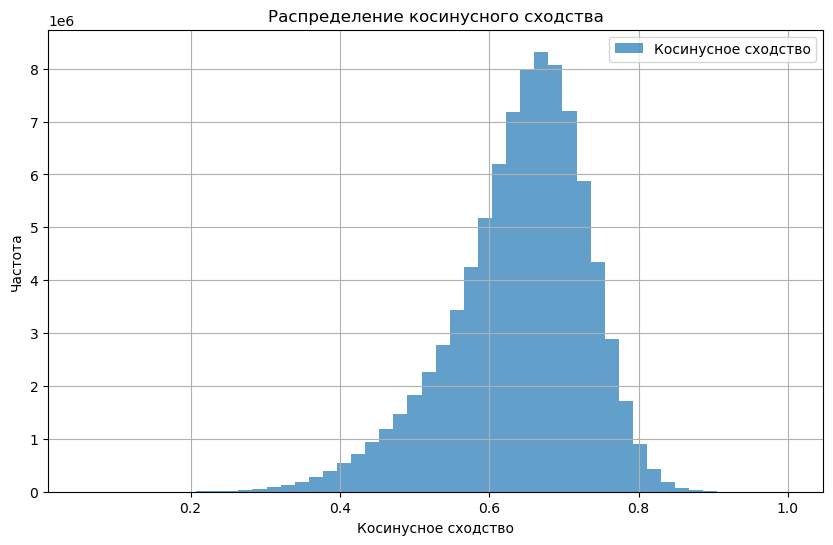

0.0

In [8]:
# Загружаем эмбеддинги и данные
response_embeddings = load_embeddings(os.path.join(OUTPUT_DIR, 'response_embeddings.npy'))
df = load_data(DATA_PATH)

# Пример инференса
context = "Why are you late?"
best_response = infer(context, response_embeddings, df, model, tokenizer)
print(f"Контекст: {context}")
print(f"Ответ: {best_response}")

# Валидация модели
validate(response_embeddings, df, model, tokenizer)